In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import import_ipynb
import WheatDataset
from WheatDataset import WheatDataset

from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img
from detection_transforms import Compose, PILToTensor, ConvertImageDtype, RandomHorizontalFlip
from detection_utils import collate_fn

import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes

import numpy as np
import math
import copy
import cv2
import os


In [123]:
root = "/home/emj6571/wheat_counting/dataset"
model_path = "/home/emj6571/wheat_counting/model"
folder_img = list(sorted(os.listdir(os.path.join(root, "images"))))
image_path = os.path.join(root, "pictures", "DOP_AD22_HZ_D10_RGB_18mm_UTM32__multi_band____parcel_100_buff_0__geotiff.tif")
folder_mask = list(sorted(os.listdir(os.path.join(root, "masks"))))
mask_path = os.path.join(root, "masks", "DOP_AD22_HZ_D10_RGB_18mm_UTM32__multi_band____parcel_100_buff_0__geotiff.png")

In [124]:
root = "/home/emj6571/wheat_counting/dataset"
image_path = "/home/emj6571/wheat_counting/dataset/images/DOP_AD22_HZ_D10_RGB_18mm_UTM32__multi_band____parcel_100_buff_0__geotiff.tif"
annotations_path = "/home/emj6571/wheat_counting/dataset/annotations.json"

In [125]:
model_path = "/home/emj6571/wheat_counting/model_saves/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path)

image_path = "/home/emj6571/wheat_counting/dataset/test/test_file_big_1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, dsize=(521, 1721))

In [126]:
image

array([[[ 48,  58,  34],
        [ 57,  67,  43],
        [ 86,  96,  72],
        ...,
        [103, 103,  75],
        [132, 132, 104],
        [137, 137, 109]],

       [[ 66,  76,  52],
        [ 92, 102,  78],
        [129, 139, 115],
        ...,
        [119, 119,  91],
        [107, 107,  79],
        [ 85,  85,  56]],

       [[101, 111,  87],
        [131, 141, 117],
        [152, 162, 138],
        ...,
        [ 90,  90,  63],
        [ 61,  61,  33],
        [ 50,  50,  22]],

       ...,

       [[ 61,  45,  25],
        [ 61,  48,  26],
        [ 65,  53,  31],
        ...,
        [ 37,  41,  27],
        [ 44,  48,  34],
        [ 50,  54,  40]],

       [[ 66,  49,  29],
        [ 66,  51,  30],
        [ 65,  50,  29],
        ...,
        [ 43,  47,  33],
        [ 46,  50,  35],
        [ 52,  56,  41]],

       [[ 68,  51,  31],
        [ 67,  50,  30],
        [ 59,  44,  23],
        ...,
        [ 46,  50,  36],
        [ 43,  47,  32],
        [ 47,  51,  36]]

# Something else

In [127]:
# prediction of model
def predict_image_window(model, image_window, score_threshold):
    image_window = Image.fromarray(image_window)
    image_window = get_transform_torch_img(image_window).cuda() / 255
    prediction = model([image_window])

    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    prediction[0]["boxes"] = prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
    prediction[0]["labels"] = prediction[0]["labels"][:len(prediction[0]["boxes"])]
    prediction[0]["masks"] = prediction[0]["masks"][prediction[0]["scores"] > score_threshold]
    prediction[0]["scores"] = prediction[0]["scores"][:len(prediction[0]["boxes"])]

    return prediction[0]

In [128]:
score_threshold = 0.7
mask_threshold = 0.5

In [129]:
def main(model, image, score_threshold, mask_threshold):
    images = []
    tmp = image
    step_size = 240
    num_columns = math.floor(image.shape[1] / step_size)
    (w_width, w_height) = (280, 280)
    for x in range(0, image.shape[1] - w_width , step_size):       # width
        for y in range(0, image.shape[0] - w_height, step_size):    # heigth
            image_window = image[y:y + w_height, x:x + w_width, :]
            images.append(image_window)
            # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2)   # show crops
            
    predictions = []
    n_wheatheads = 0
    x_cut, y_cut = 40, 40 
    for i, image in enumerate(images, start=1):
        prediction = predict_image_window(model, image, score_threshold)
        predictions.append(prediction)
        
    # n_wheatheads, predictions_uncut, predictions_cut = get_wheathead_counts(predictions, 
    #                                                                         images, 
    #                                                                         x_cut, 
    #                                                                         y_cut)

    # x_list, y_list = calc_all_box_centers(predictions)
    # modified_x, modified_y = modify_x_y(x_list, y_list)

    return images, predictions, n_wheatheads

In [130]:
images, predictions, n_wheatheads = main(model, image, score_threshold, mask_threshold)

In [131]:
# calculate center of bounding boxes
def get_box_center(boxes):
    x_center, y_center = [], []
    for box in boxes:
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
        x_mid = x1 + ((x2-x1) / 2)
        y_mid = y1 + ((y2-y1) / 2)
        x_center.append(x_mid)
        y_center.append(y_mid)
    return x_center, y_center

In [132]:
# get center of boxes for all predictions
def calc_all_box_centers(predictions):
    x_list, y_list = [], []
    for prediction in predictions:
        x_center, y_center = get_box_center(prediction["boxes"])
        x_list.append(x_center)
        y_list.append(y_center)
    return x_list, y_list

In [133]:
# get counts of wheat heads for all images
def get_grid_counts(predictions, gridsize_heatmap, cells):
    all_grids = []
    # get center points of all bounding boxes
    x_list, y_list = calc_all_box_centers(predictions)

    # iterate over all x,y coordiantes and count for each grid cell
    for i in range(len(x_list)):
        grid_counts = [[0 for j in range(cells)] for i in range(cells)]
        centers = zip(x_list[i], y_list[i])
        for x,y in centers:
            row_index = int(y // gridsize_heatmap)
            col_index = int(x // gridsize_heatmap)
            grid_counts[row_index][col_index] += 1
        all_grids.append(grid_counts)

    return all_grids

In [134]:
# generates images with bbs and masks for stitiching and plotting
def generate_stitched_images(predictions, images):
    plot_images = []
    n_detections = []
    for i, target in enumerate(predictions):
        image = torch.from_numpy(images[i]).permute(2,0,1)
        n_detection = target["labels"][target["scores"] > score_threshold]
        boxes_threshold = target["boxes"][target["scores"] > score_threshold]
        masks_threshold = (target["masks"][target["scores"] > score_threshold].squeeze(1)).sum(dim=0) > mask_threshold
        boxes = draw_bounding_boxes(image, boxes_threshold, colors=(255,0,0))
        masks = draw_segmentation_masks(boxes, masks_threshold, colors=(0,0,255), alpha=0.5).permute(1,2,0)
        transform = T.ToPILImage()
        plot_images.append(transform(masks.permute(2,0,1)))
        n_detections.append(n_detection)
    return plot_images, n_detections

In [135]:
def create_dictionaries(new_boxes, new_scores, new_masks, new_labels,
                        overlap_boxes, overlap_scores, overlap_masks, overlap_labels):

    predictions_uncut = {"boxes" : torch.Tensor(new_boxes),
                         "scores" : torch.Tensor(new_scores),
                         "masks" : torch.stack(new_masks),
                         "labels" : torch.Tensor(new_labels)}

    predictions_cut = {"boxes" : torch.Tensor(overlap_boxes),
                        "scores" : torch.Tensor(overlap_scores),
                        "masks" : torch.stack(overlap_masks),
                        "labels" : torch.Tensor(overlap_labels)}
    
    return predictions_uncut, predictions_cut

In [136]:
# (boxes[0] > 0 + x_cut) -> cuts left side
# (boxes[1] > 0 + y_cut) -> cuts top side
# (boxes[2] < image_window.shape[1] - x_cut) cuts right side
# (boxes[3] < image_window.shape[1] - y_cut) cuts bottom side

In [137]:
def get_overlapping_predictions_top_left(prediction, image_window, x_cut, y_cut):
    new_boxes, new_scores, new_masks, new_labels = [], [], [], []
    overlap_boxes, overlap_scores, overlap_masks, overlap_labels = [], [], [], []
    for i, boxes in enumerate(prediction["boxes"]):
        if (boxes[3] < image_window.shape[1] - y_cut): #and (boxes[2] < image_window.shape[1] - x_cut):
            new_boxes.append(list(boxes))
            new_scores.append(prediction["scores"][i])
            new_masks.append(prediction["masks"][i])
            new_labels.append(prediction["labels"][i])
        else:
            overlap_boxes.append(list(boxes))
            overlap_scores.append(prediction["scores"][i])
            overlap_masks.append(prediction["masks"][i])
            overlap_labels.append(prediction["labels"][i])
        
    predictions_uncut, predictions_cut = create_dictionaries(new_boxes, new_scores, new_masks, new_labels,
                                                             overlap_boxes, overlap_scores, overlap_masks, overlap_labels)

    return predictions_uncut, predictions_cut

In [138]:
#(boxes[3] < image_window.shape[1] - y_cut) and (boxes[2] < image_window.shape[1] - x_cut) and 

In [139]:
def get_overlapping_predictions(prediction, image_window, x_cut, y_cut, counter):
    new_boxes, new_scores, new_masks, new_labels = [], [], [], []
    overlap_boxes, overlap_scores, overlap_masks, overlap_labels = [], [], [], []
    for i, boxes in enumerate(prediction["boxes"]):
        if counter == 1:
            if (boxes[1] > 0 + y_cut):
                new_boxes.append(list(boxes))
                new_scores.append(prediction["scores"][i])
                new_masks.append(prediction["masks"][i])
                new_labels.append(prediction["labels"][i])
            else:
                overlap_boxes.append(list(boxes))
                overlap_scores.append(prediction["scores"][i])
                overlap_masks.append(prediction["masks"][i])
                overlap_labels.append(prediction["labels"][i])
        elif counter == 2:
            if (boxes[3] < image_window.shape[1] - y_cut) and (boxes[0] > 0 + x_cut) and (boxes[1] > 0 + y_cut):
                new_boxes.append(list(boxes))
                new_scores.append(prediction["scores"][i])
                new_masks.append(prediction["masks"][i])
                new_labels.append(prediction["labels"][i])
            else:
                overlap_boxes.append(list(boxes))
                overlap_scores.append(prediction["scores"][i])
                overlap_masks.append(prediction["masks"][i])
                overlap_labels.append(prediction["labels"][i])
    
    predictions_uncut, predictions_cut = create_dictionaries(new_boxes, new_scores, new_masks, new_labels,
                                                             overlap_boxes, overlap_scores, overlap_masks, overlap_labels)

    return predictions_uncut, predictions_cut

In [140]:
def filter_boxes_over_area(boxes1, boxes2):
  # combines all boxes
  boxes = torch.cat((boxes1, boxes2), dim=0)
  boxes = sorted(boxes, key=lambda x: x[0])
  boxes = torch.stack(boxes)

  # create mask for duplicates to filter via coordiante differences
  diff = boxes[1:] - boxes[:-1]
  mask = (diff[:, 0] > 1) | (diff[:, 1] > 1) | (diff[:, 2] > 1) | (diff[:, 3] > 1)
  print(mask)
  mask = torch.cat([mask, torch.tensor([True])])
  filtered_boxes = boxes[mask]

  return filtered_boxes

In [141]:
# plot of images created by sliding window
def plot_predicted_img(image_nr_a, image_nr_b, 
                        score_threshold, mask_threshold, 
                        stitch_bottom, n_wheatheads,
                        predictions, images,
                        all_grids):

    cut = 30

    predictions_uncut_tl, predictions_cut_tl = get_overlapping_predictions_top_left(predictions[image_nr_a], images[image_nr_a], cut, cut)
    predictions_uncut, predictions_cut = get_overlapping_predictions(predictions[image_nr_b], images[image_nr_b], cut, cut, 1)


    new_boxes_1 = []
    for boxes in predictions_cut_tl["boxes"]:
        x1, y1, x2, y2 = boxes
        if not(y2 > 277) or not(x2 > 277):
            boxes = x1, y1, x2, y2
            new_boxes_1.append(boxes)
    new_boxes_1 = torch.Tensor(new_boxes_1)

    new_boxes_2 = []
    for boxes in predictions_cut["boxes"]:
        x1, y1, x2, y2 = boxes
        if not(y1 < 3):
            boxes = x1, y1+240, x2, y2+240
            new_boxes_2.append(boxes)
    new_boxes_2 = torch.Tensor(new_boxes_2)

    boxes = filter_boxes_over_area(new_boxes_2, new_boxes_1)

    iou_boxes = []
    for box in boxes:
        if box != None:
            iou_boxes.append(box)

    iou_boxes = torch.stack(iou_boxes)
    print(iou_boxes)

    




    image_a = torch.from_numpy(images[image_nr_a]).permute(2,0,1)
    n_detection_a = predictions_cut_tl["labels"][predictions_cut_tl["scores"] > score_threshold]
    boxes_threshold = predictions_cut_tl["boxes"][predictions_cut_tl["scores"] > score_threshold]
    masks_threshold = (predictions_cut_tl["masks"][predictions_cut_tl["scores"] > score_threshold].squeeze(1)).sum(dim=0) > mask_threshold
    boxes_a = draw_bounding_boxes(image_a, boxes_threshold, colors=(255,0,0))
    masks_a = draw_segmentation_masks(boxes_a, masks_threshold, colors=(0,0,255), alpha=0.5).permute(1,2,0)

    image_b = torch.from_numpy(images[image_nr_b]).permute(2,0,1)
    n_detection_b = predictions_cut["labels"][predictions_cut["scores"] > score_threshold]
    boxes_threshold = predictions_cut["boxes"][predictions_cut["scores"] > score_threshold]
    masks_threshold = (predictions_cut["masks"][predictions_cut["scores"] > score_threshold].squeeze(1)).sum(dim=0) > mask_threshold
    boxes_b = draw_bounding_boxes(image_b, boxes_threshold, colors=(255,0,0))
    masks_b = draw_segmentation_masks(boxes_b, masks_threshold, colors=(0,0,255), alpha=0.5).permute(1,2,0)

    boxes = draw_bounding_boxes(image_a, iou_boxes, colors=(255,0,0))
    masks_c = draw_segmentation_masks(boxes, masks_threshold, colors=(0,0,255), alpha=0.5).permute(1,2,0)

    f = plt.figure(figsize=(30,16))
    f.add_subplot(1,3,1)
    plt.title("Image A - Image Number: " + str(image_nr_a) + " - Wheat Counts: " + str(len(n_detection_a)), fontsize=20)
    plt.imshow(boxes_a.permute(1,2,0))
    f.add_subplot(1,3,2)
    plt.title("Image B - Image Number: " + str(image_nr_b) + " - Wheat Counts: " + str(len(n_detection_b)), fontsize=20)
    plt.imshow(boxes_b.permute(1,2,0))
    f.add_subplot(1,3,3)
    plt.title(f"Both: {len(iou_boxes)}", fontsize=20)
    plt.imshow(boxes.permute(1,2,0))
    
    plt.show(block=True)

tensor([False,  True, False,  True, False,  True, False,  True,  True, False,
         True, False,  True, False,  True, False,  True,  True, False])
tensor([[  0.0000, 258.7304,   8.1335, 269.5301],
        [  9.7202, 265.4181,  19.0172, 274.9529],
        [ 22.8004, 255.8387,  37.2807, 270.2905],
        [ 38.7299, 250.4854,  56.0871, 269.3711],
        [ 50.1630, 273.4110,  59.5470, 280.0000],
        [138.7800, 261.7014, 147.2255, 270.6275],
        [148.1363, 252.8031, 160.8470, 266.5016],
        [193.8567, 266.2882, 205.2455, 277.7981],
        [196.9789, 248.5725, 209.7630, 261.9211],
        [226.8952, 233.6819, 242.3761, 250.7243],
        [262.5215, 255.1169, 275.4457, 268.1151]])


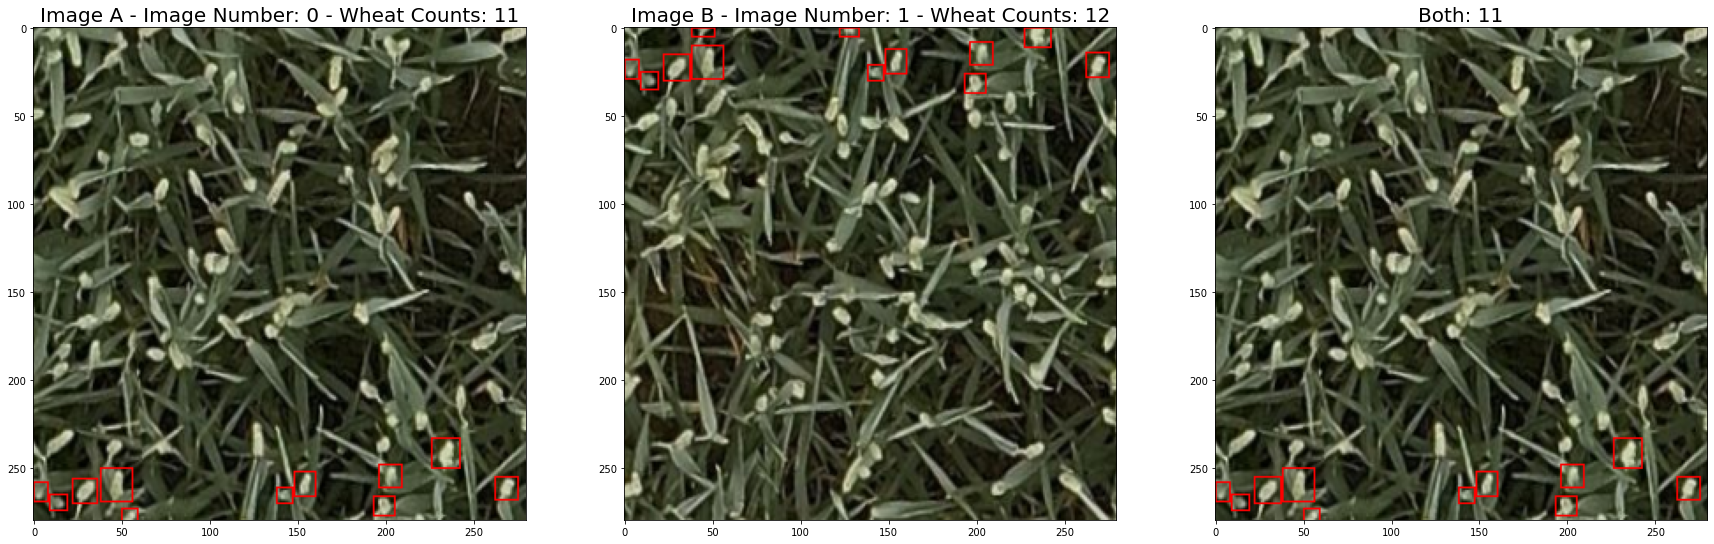

In [142]:
# for detection
image_nr_a = 0
image_nr_b = 1
stitch_bottom = True

# for heatmap
image_idx = 0
gridsize_heatmap = 40
cells = int(280 / gridsize_heatmap)

all_grids = get_grid_counts(predictions, gridsize_heatmap, cells)

plot_predicted_img(image_nr_a, 
                    image_nr_b, 
                    score_threshold, 
                    mask_threshold, 
                    stitch_bottom,
                    n_wheatheads,
                    predictions,
                    images,
                    all_grids)

In [143]:
root = "/home/emj6571/wheat_counting/dataset"
image_path = "/home/emj6571/wheat_counting/dataset/images/DOP_AD22_HZ_D10_RGB_18mm_UTM32__multi_band____parcel_100_buff_0__geotiff.tif"
annotations_path = "/home/emj6571/wheat_counting/dataset/annotations.json"

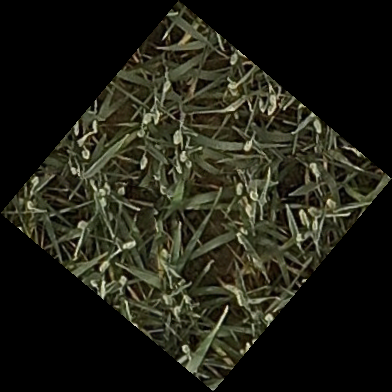

In [144]:
image = Image.open(image_path)
image